# 日本語EDA（全文・全品詞）
UDHR日本語版を対象に、品詞制限なしでトークン化し、英語EDAと同一の流れで解析します。

## 1. セットアップ

In [1]:
import nltk
nltk.download("udhr")

from nltk.corpus import udhr
import itertools
from collections import Counter

# MeCab
try:
    import MeCab
    MECAB_OK = True
except Exception as e:
    MECAB_OK = False
    print("MeCabのインポートに失敗しました。: ", e)

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import ipadic

# 日本語フォント
rcParams['axes.unicode_minus'] = False
# rcParams['font.family'] = 'Meiryo'  # Windows
rcParams['font.family'] = 'Hiragino Sans'  # macOS
# rcParams['font.family'] = 'Noto Sans CJK JP'  # Linux

print("環境準備完了")

[nltk_data] Downloading package udhr to
[nltk_data]     /Users/takatakiyugo/nltk_data...
[nltk_data]   Package udhr is already up-to-date!


環境準備完了


## 2. データ読み込み

In [2]:
# UDHR 日本語版を全文読み込み
text = udhr.raw("Japanese_Nihongo-UTF8")

# 文単位に分割
sentences = [s.strip() for s in text.split("。") if s.strip()]
docs = {i: (s + "。") for i, s in enumerate(sentences)}

print(f"文書数: {len(docs)}")
print("----- 先頭3文 ----")
for i in range(3):
    print(f"[{i}] {docs[i]}")

文書数: 49
----- 先頭3文 ----
[0] 『世界人権宣言』
 

（1948.12.10 第３回国連総会採択）

 

〈前文〉
　
人類社会のすべての構成員の固有の尊厳と平等で譲ることのできない権利とを承認することは、世界における自由、正義及び平和の基礎であるので、

人権の無視及び軽侮が、人類の良心を踏みにじった野蛮行為をもたらし、言論及び信仰の自由が受けられ、恐怖及び欠乏のない世界の到来が、一般の人々の最高の願望として宣言されたので、　

人間が専制と圧迫とに対する最後の手段として反逆に訴えることがないようにするためには、法の支配によって人権を保護することが肝要であるので、

諸国間の友好関係の発展を促進することが肝要であるので、

国際連合の諸国民は、国連憲章において、基本的人権、人間の尊厳及び価値並びに男女の同権についての信念を再確認し、かつ、一層大きな自由のうちで社会的進歩と生活水準の向上とを促進することを決意したので、 　

加盟国は、国際連合と協力して、人権及び基本的自由の普遍的な尊重及び遵守の促進を達成することを誓約したので、 

　
これらの権利及び自由に対する共通の理解は、この誓約を完全にするためにもっとも重要であるので、 　


よって、ここに、国連総会は、 　


社会の各個人及び各機関が、この世界人権宣言を常に念頭に置きながら、加盟国自身の人民の間にも、また、加盟国の管轄下にある地域の人民の間にも、これらの権利と自由との尊重を指導及び教育によって促進すること並びにそれらの普遍的措置によって確保することに努力するように、すべての人民とすべての国とが達成すべき共通の基準として、この人権宣言を公布する。
[1] 第１条
すべての人間は、生まれながらにして自由であり、かつ、尊厳と権利と について平等である。
[2] 人間は、理性と良心とを授けられており、互いに同 胞の精神をもって行動しなければならない。


## 3. トークン化（品詞制限なし）

In [3]:
if not MECAB_OK:
    raise RuntimeError("MeCabが利用できません。インストールしてください。")

tagger = MeCab.Tagger(ipadic.MECAB_ARGS + " -Ochasen")

def tokenize(text):
    node = tagger.parseToNode(text)
    tokens = []
    while node:
        surface = node.surface
        if surface:  # 空でなければ追加
            tokens.append(surface)
        node = node.next
    return tokens

# 全文書をトークン化
tokenized_docs = {i: tokenize(doc) for i, doc in docs.items()}
print(tokenized_docs[0][:30])

['『', '世界', '人権', '宣言', '』', '（', '1948', '.', '12', '.', '10', '第', '３', '回', '国連', '総会', '採択', '）', '〈', '前文', '〉', '\u3000', '人類', '社会', 'の', 'すべて', 'の', '構成', '員', 'の']


## 4. 文書長分布

平均文書長: 40.16
最長文書長: 405
最短文書長: 13


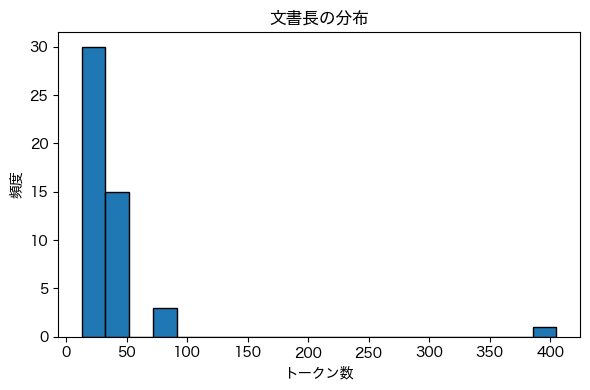

In [4]:
doc_lengths = [len(tokens) for tokens in tokenized_docs.values()]
print(f"平均文書長: {sum(doc_lengths)/len(doc_lengths):.2f}")
print(f"最長文書長: {max(doc_lengths)}")
print(f"最短文書長: {min(doc_lengths)}")

plt.figure(figsize=(6,4))
plt.hist(doc_lengths, bins=20, edgecolor="black")
plt.title("文書長の分布")
plt.xlabel("トークン数")
plt.ylabel("頻度")
plt.tight_layout()
plt.show()

## 5. トークン頻度

In [5]:
all_tokens = list(itertools.chain.from_iterable(tokenized_docs.values()))
freq = Counter(all_tokens)
freq.most_common(20)

[('、', 161),
 ('の', 116),
 ('を', 99),
 ('は', 59),
 ('に', 52),
 ('。', 49),
 ('権利', 37),
 ('及び', 35),
 ('人', 33),
 ('と', 32),
 ('する', 32),
 ('すべて', 31),
 ('有する', 29),
 ('こと', 26),
 ('条', 26),
 ('第', 25),
 ('\u3000', 25),
 ('な', 25),
 ('自由', 23),
 ('又は', 22)]

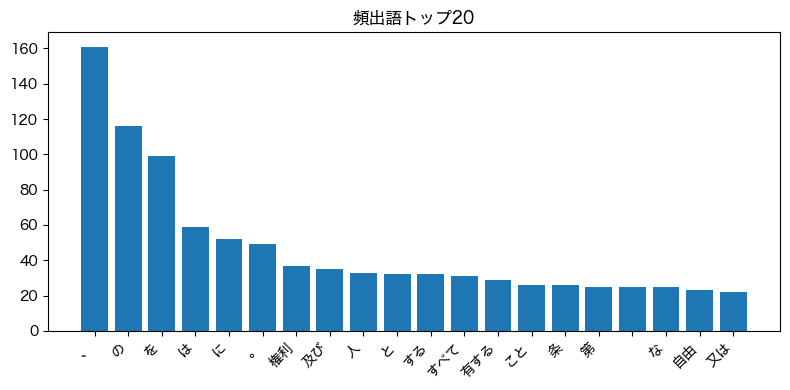

In [6]:
labels, values = zip(*freq.most_common(20))
plt.figure(figsize=(8,4))
plt.bar(labels, values)
plt.title("頻出語トップ20")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 6. Zipfの法則

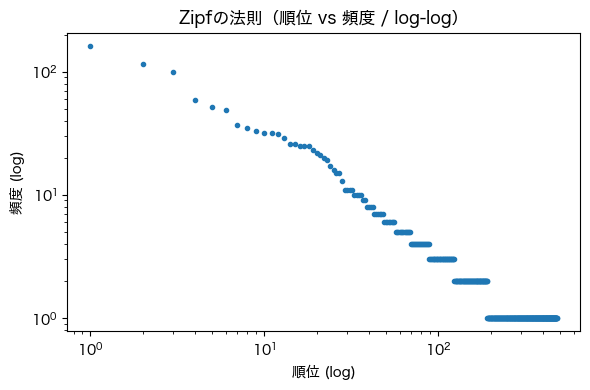

In [7]:
sorted_counts = [c for _, c in freq.most_common()]
ranks = range(1, len(sorted_counts)+1)

plt.figure(figsize=(6,4))
plt.loglog(ranks, sorted_counts, marker=".", linewidth=0)
plt.title("Zipfの法則（順位 vs 頻度 / log-log）")
plt.xlabel("順位 (log)")
plt.ylabel("頻度 (log)")
plt.tight_layout()
plt.show()

## 7. Biword（連接2語）

In [8]:
def biwords(tokens):
    return [f"{a} {b}" for a, b in zip(tokens, tokens[1:])]

all_bi = list(itertools.chain.from_iterable(biwords(tokens) for tokens in tokenized_docs.values()))
bi_freq = Counter(all_bi)
bi_freq.most_common(20)

[('は 、', 46),
 ('を 有する', 28),
 ('権利 を', 27),
 ('有する 。', 26),
 ('人 は', 24),
 ('条 すべて', 19),
 ('すべて 人', 16),
 ('ない 。', 14),
 ('すべて の', 13),
 ('も 、', 13),
 ('\u3000 \u3000', 12),
 ('を 受ける', 12),
 ('する こと', 9),
 ('こと は', 9),
 ('何 人', 8),
 ('人 も', 8),
 ('受ける 権利', 8),
 ('自己 の', 8),
 ('する 権利', 8),
 ('で ある', 7)]

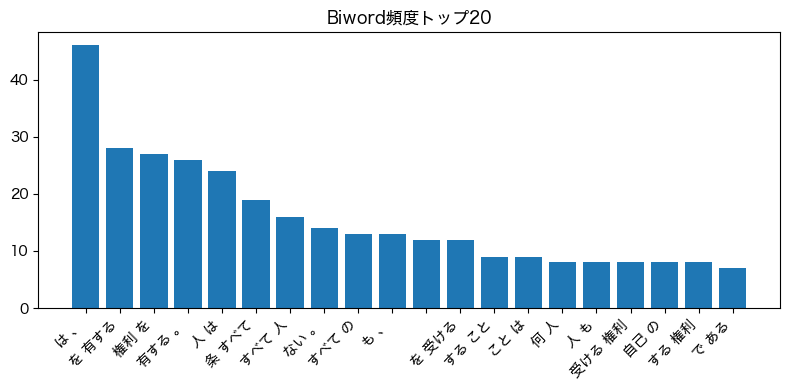

In [9]:
labels, values = zip(*bi_freq.most_common(20))
plt.figure(figsize=(8,4))
plt.bar(labels, values)
plt.title("Biword頻度トップ20")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 8. まとめ
- UDHR日本語版全文を対象に、品詞制限なしでトークン化を実施。
- 文書長分布、頻度上位語、Zipfの法則、Biword頻度を確認。
- 英語EDAと同様の流れで、日本語コーパスにおける基本的な分布特性を把握。